In [13]:
from pathlib import Path
import sys

# Raíz del repo y carpetas
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

OUT = ROOT / "outputs"
SUMMARY = OUT / "summary"
SUMMARY.mkdir(parents=True, exist_ok=True)

print("ROOT   :", ROOT)
print("OUT    :", OUT)
print("SUMMARY:", SUMMARY)


ROOT   : /home/cesar/proyectos/TFM_SNN
OUT    : /home/cesar/proyectos/TFM_SNN/outputs
SUMMARY: /home/cesar/proyectos/TFM_SNN/outputs/summary


In [14]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.results_io import build_results_table
from src.plots import plot_across_runs, plot_loss_curves_for_run  # opcional (loss)

# Normalizador de nombres de método (robusto)
def canonical_method(s: str) -> str:
    if not isinstance(s, str):
        return "unknown"
    t = s.lower()

    # combinaciones primero
    if ("rehearsal" in t) and ("+ewc" in t or "_ewc" in t):
        return "rehearsal+ewc"

    # familias específicas SNN
    if "sca-snn" in t:                 # captura 'sca-snn_bins50_...' etc.
        return "sca-snn"
    if re.search(r"\bsa[-_]snn\b", t):
        return "sa-snn"
    if re.search(r"\bas[-_]snn\b", t):
        return "as-snn"
    if "colanet" in t:
        return "colanet"

    # genéricos
    if re.search(r"\bewc\b", t) or "ewc_lam" in t:
        return "ewc"
    if "rehearsal" in t:
        return "rehearsal"
    if "naive" in t or "finetune" in t or "fine-tune" in t:
        return "naive"

    # fallback
    return t.split("_")[0]

def minmax(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    lo, hi = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return pd.Series(np.where(s.notna(), 0.0, np.nan), index=s.index)
    return (s - lo) / (hi - lo)

def norm01(x: np.ndarray) -> np.ndarray:
    x = x.astype(float)
    lo, hi = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.ones_like(x) * 0.5
    return (x - lo) / (hi - lo)


In [15]:
df = build_results_table(OUT)
display(df)

tbl_path = SUMMARY / "results_table.csv"
df.to_csv(tbl_path, index=False)
print(f"[OK] Tabla consolidada guardada en: {tbl_path}")

# (Opcional) métricas globales de cobertura
print("\nCobertura por preset:")
display(df["preset"].value_counts(dropna=False))
print("\nCobertura por método (crudo, sin normalizar):")
display(df["method"].value_counts(dropna=False))


,run_dir,preset,method,encoder,model,seed,T,B,amp,params,...,telemetry_elapsed_sec,telemetry_emissions_kg,circuito1_best_mae,circuito1_final_mae,circuito1_forget_abs,circuito1_forget_rel,circuito2_best_mae,circuito2_final_mae,circuito2_forget_abs,circuito2_forget_rel
0,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,accurate,as-snn_gr_0.3_lam_1.59168,rate,PilotNetSNN_66x200_gray,42,30.0,32.0,True,251027.0,...,20211.601102,0.065574,0.124857,0.158338,0.033481,0.268158,0.134521,0.134521,0.0,0.0
1,continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...,accurate,ewc_lam_7e+08,rate,PilotNetSNN_66x200_gray,42,30.0,32.0,True,251027.0,...,19930.428739,0.071978,0.124857,0.149030,0.024173,0.193607,0.198404,0.198404,0.0,0.0
2,continual_accurate_naive_rate_model-PilotNetSN...,accurate,naive,rate,PilotNetSNN_66x200_gray,42,30.0,32.0,True,251027.0,...,19536.322868,0.085207,0.127295,0.158632,0.031337,0.246175,0.134778,0.134778,0.0,0.0
3,continual_accurate_rehearsal_buf_3000_rr_10_ra...,accurate,rehearsal_buf_3000_rr_10,rate,PilotNetSNN_66x200_gray,42,30.0,32.0,True,251027.0,...,19506.329787,0.072408,0.120410,0.151986,0.031575,0.262231,0.136821,0.136821,0.0,0.0
4,continual_accurate_rehearsal_buf_3000_rr_20_ra...,accurate,rehearsal_buf_3000_rr_20,rate,PilotNetSNN_66x200_gray,42,30.0,32.0,True,251027.0,...,29089.454519,0.104044,0.124500,0.151833,0.027333,0.219538,0.141332,0.141332,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,continual_std_ewc_lam_7e+08_lam_7e+08_ewc_hpo_...,std,ewc_lam_7e+08_lam_7e+08_ewc_hpo_t2_lam_7.0e+08,rate,PilotNetSNN,42,NaN,96.0,False,NaN,...,NaN,NaN,0.140915,0.172076,0.031161,0.221133,0.201512,0.201512,0.0,0.0
73,continual_std_naive_rate_model-PilotNetSNN_66x...,std,naive,rate,PilotNetSNN,42,NaN,56.0,True,NaN,...,NaN,NaN,0.127417,0.163961,0.036545,0.286812,0.139246,0.139246,0.0,0.0
74,continual_std_rehearsal_buf_3000_rr_10_rate_mo...,std,rehearsal_buf_3000_rr_10,rate,PilotNetSNN,42,NaN,56.0,True,NaN,...,NaN,NaN,0.128092,0.151696,0.023604,0.184272,0.143461,0.143461,0.0,0.0
75,continual_std_rehearsal_buf_3000_rr_10+ewc_lam...,std,rehearsal_buf_3000_rr_10+ewc_lam_7e+08_lam_7e+08,rate,PilotNetSNN,42,NaN,56.0,True,NaN,...,NaN,NaN,0.125205,0.173030,0.047825,0.381972,0.229081,0.229081,0.0,0.0


[OK] Tabla consolidada guardada en: /home/cesar/proyectos/TFM_SNN/outputs/summary/results_table.csv

Cobertura por preset:


preset
fast        35
std         28
accurate    14
Name: count, dtype: int64


Cobertura por método (crudo, sin normalizar):


method
as-snn_gr_0.3_lam_1.59168                            5
naive                                                3
rehearsal_buf_3000_rr_10                             3
ewc_lam_7e+08                                        2
sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0    2
                                                    ..
ewc_lam_4e+08_lam_4e+08_ewc_hpo_t3_lam_4.0e+08       1
ewc_lam_5e+07_lam_5e+07_ewc_hpo_t4_lam_5.0e+07       1
ewc_lam_7e+08_lam_7e+08                              1
ewc_lam_7e+08_lam_7e+08_ewc_hpo_t0_lam_7.0e+08       1
ewc_lam_7e+08_lam_7e+08_ewc_hpo_t2_lam_7.0e+08       1
Name: count, Length: 61, dtype: int64

[CHECK] method_base:
method_base
as-snn           1
ewc              1
naive            1
rehearsal        2
rehearsal+ewc    1
sa-snn           5
sca-snn          3
Name: count, dtype: int64
[INFO] Tareas detectadas (final_mae): ['circuito1_final_mae', 'circuito2_final_mae']
[INFO] Usando para ranking/pareto: circuito2_final_mae
[OK] Pareto accurate → /home/cesar/proyectos/TFM_SNN/outputs/summary/pareto_accurate.csv
[OK] Top-6 accurate → /home/cesar/proyectos/TFM_SNN/outputs/summary/top6_accurate.csv
[OK] Ganadores por método (accurate) → /home/cesar/proyectos/TFM_SNN/outputs/summary/winners_accurate_per_method.csv
[OK] scatter (todos accurate) → /home/cesar/proyectos/TFM_SNN/outputs/summary/scatter_accurate_mae_vs_forget.png
[OK] scatter (winners) → /home/cesar/proyectos/TFM_SNN/outputs/summary/scatter_winners_accurate.png


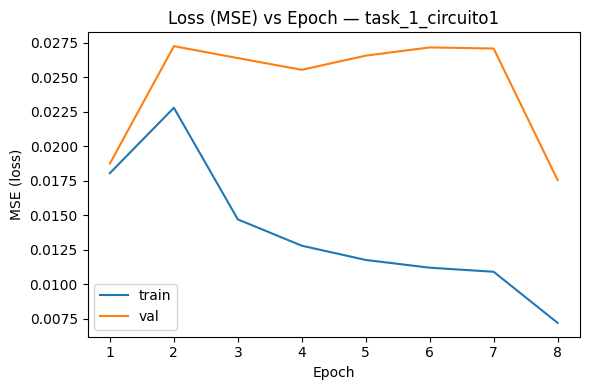

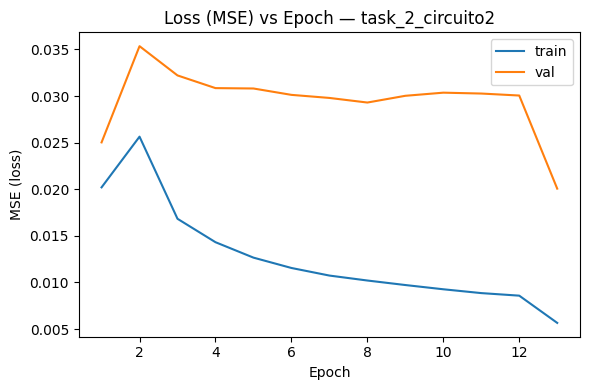

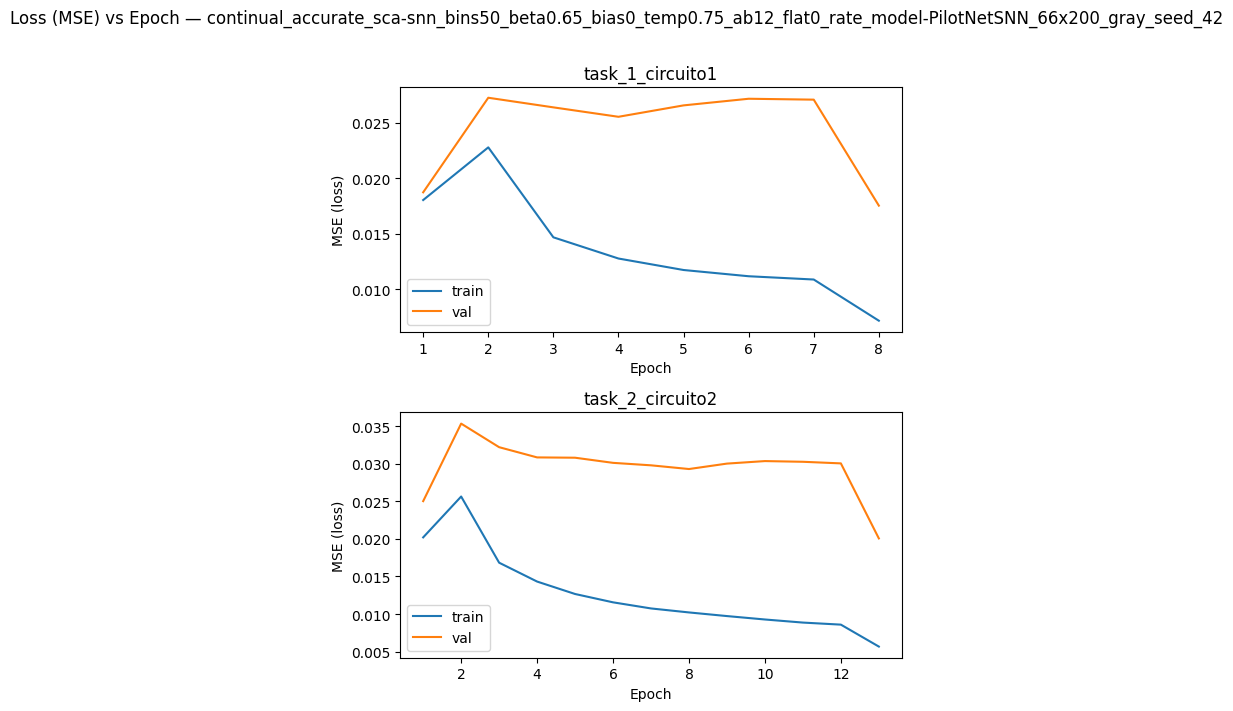

[OK] Curvas de loss del mejor run → /home/cesar/proyectos/TFM_SNN/outputs/summary/continual_accurate_sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0_rate_model-PilotNetSNN_66x200_gray_seed_42

=== Frente de Pareto (accurate) ===


,run_dir,preset,method_base,method,encoder,model,seed,elapsed_sec,emissions_kg,avg_forget_rel,circuito2_final_mae
0,continual_accurate_sa-snn_k8_tau28_th1-2_p2000...,accurate,sa-snn,sa-snn_k8_tau28_th1-2_p2000000,rate,PilotNetSNN_66x200_gray,42,25313.433069,0.079970,0.227382,0.131236
1,continual_accurate_sca-snn_bins50_beta0.6_bias...,accurate,sca-snn,sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_f...,rate,PilotNetSNN_66x200_gray,42,24126.103368,0.080034,0.185192,0.131880
2,continual_accurate_sca-snn_bins50_beta0.65_bia...,accurate,sca-snn,sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0,rate,PilotNetSNN_66x200_gray,42,24297.300170,0.076519,0.095610,0.132231
3,continual_accurate_sa-snn_k8_tau32_th1-2_p5000...,accurate,sa-snn,sa-snn_k8_tau32_th1-2_p5000000,rate,PilotNetSNN_66x200_gray,42,22102.547832,0.070985,0.276594,0.134447
4,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,accurate,as-snn,as-snn_gr_0.3_lam_1.59168,rate,PilotNetSNN_66x200_gray,42,20211.601102,0.065574,0.134079,0.134521
5,continual_accurate_rehearsal_buf_3000_rr_10_ra...,accurate,rehearsal,rehearsal_buf_3000_rr_10,rate,PilotNetSNN_66x200_gray,42,19506.329787,0.072408,0.131116,0.136821
6,continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...,accurate,ewc,ewc_lam_7e+08,rate,PilotNetSNN_66x200_gray,42,19930.428739,0.071978,0.096803,0.198404
7,continual_accurate_rehearsal_buf_3000_rr_20+ew...,accurate,rehearsal+ewc,rehearsal_buf_3000_rr_20+ewc_lam_1e+09,rate,PilotNetSNN_66x200_gray,42,29488.605843,0.104276,0.000000,0.201058



=== Top-6 accurate por score compuesto (↓ mejor) ===


,run_dir,method_base,seed,circuito2_final_mae,avg_forget_rel,emissions_kg,score
11,continual_accurate_sca-snn_bins50_beta0.65_bia...,sca-snn,42,0.132231,0.095610,0.076519,0.108440
0,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,as-snn,42,0.134521,0.134079,0.065574,0.136238
3,continual_accurate_rehearsal_buf_3000_rr_10_ra...,rehearsal,42,0.136821,0.131116,0.072408,0.163293
2,continual_accurate_naive_rate_model-PilotNetSN...,naive,42,0.134778,0.123087,0.085207,0.166393
12,continual_accurate_sca-snn_bins50_beta0.6_bias...,sca-snn,42,0.131880,0.185192,0.080034,0.187957
7,continual_accurate_sa-snn_k8_tau28_th1-2_p2000...,sa-snn,42,0.131236,0.227382,0.079970,0.218694



=== Ganadores por método (accurate) ===


,run_dir,method_base,encoder,model,seed,circuito2_final_mae,avg_forget_rel,emissions_kg
7,continual_accurate_sa-snn_k8_tau28_th1-2_p2000...,sa-snn,rate,PilotNetSNN_66x200_gray,42,0.131236,0.227382,0.079970
12,continual_accurate_sca-snn_bins50_beta0.6_bias...,sca-snn,rate,PilotNetSNN_66x200_gray,42,0.131880,0.185192,0.080034
0,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,as-snn,rate,PilotNetSNN_66x200_gray,42,0.134521,0.134079,0.065574
2,continual_accurate_naive_rate_model-PilotNetSN...,naive,rate,PilotNetSNN_66x200_gray,42,0.134778,0.123087,0.085207
3,continual_accurate_rehearsal_buf_3000_rr_10_ra...,rehearsal,rate,PilotNetSNN_66x200_gray,42,0.136821,0.131116,0.072408
1,continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...,ewc,rate,PilotNetSNN_66x200_gray,42,0.198404,0.096803,0.071978
5,continual_accurate_rehearsal_buf_3000_rr_20+ew...,rehearsal+ewc,rate,PilotNetSNN_66x200_gray,42,0.201058,0.000000,0.104276


In [16]:
# --- 1) Cargar tabla (si vienes de un kernel nuevo) ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def norm01(x):
    x = x.astype(float)
    lo, hi = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.ones_like(x) * 0.5
    return (x - lo) / (hi - lo)

if "df" not in globals():
    tbl_path = SUMMARY / "results_table.csv"
    if tbl_path.exists():
        df = pd.read_csv(tbl_path)
        print("[INFO] Tabla cargada desde:", tbl_path)
    else:
        from src.results_io import build_results_table
        df = build_results_table(OUT)
        df.to_csv(tbl_path, index=False)
        print("[INFO] Tabla construida y guardada:", tbl_path)

# --- 2) Filtra preset='accurate' y prepara columnas clave ---
df_acc = df[df["preset"] == "accurate"].copy()
if df_acc.empty:
    raise RuntimeError("No hay runs con preset='accurate' en la tabla.")

# método base normalizado (si tienes un mapeo)
df_acc["method_base"] = df_acc["method"].astype(str).apply(canonical_method)

print("[CHECK] method_base:")
print(df_acc["method_base"].value_counts(dropna=False).sort_index())

# Detecta y ordena columnas *_final_mae -> usamos la ÚLTIMA tarea
task_cols = [c for c in df_acc.columns if c.endswith("_final_mae")]
assert task_cols, "No se encuentran columnas *_final_mae en la tabla."

def sort_key(col):
    name = col.replace("_final_mae", "")
    m = re.search(r"(\d+)$", name)
    base = re.sub(r"\d+$", "", name)
    idx = int(m.group(1)) if m else 0
    return (base, idx)

task_cols_sorted = sorted(task_cols, key=sort_key)
MAE_COL = task_cols_sorted[-1]              # ← última tarea
MAE_TASK_NAME = MAE_COL.replace("_final_mae", "")
print("[INFO] Tareas detectadas (final_mae):", task_cols_sorted)
print("[INFO] Usando para ranking/pareto:", MAE_COL)

# Asegurar numéricos y existencia de columnas clave
for c in ["emissions_kg", "avg_forget_rel", MAE_COL, "elapsed_sec"]:
    if c not in df_acc.columns:
        df_acc[c] = np.nan
    df_acc[c] = pd.to_numeric(df_acc[c], errors="coerce")

# --- 3) Rellenos prudentes para poder comparar/paretizar ---
if df_acc["emissions_kg"].isna().all():
    df_acc["emissions_kg"] = 0.0
else:
    df_acc["emissions_kg"] = df_acc["emissions_kg"].fillna(df_acc["emissions_kg"].median())

if df_acc["avg_forget_rel"].isna().all():
    df_acc["avg_forget_rel"] = 0.0
else:
    # si faltan, penaliza con el peor observado
    df_acc["avg_forget_rel"] = df_acc["avg_forget_rel"].fillna(df_acc["avg_forget_rel"].max())

# --- 4) Frente de Pareto (min: MAE, olvido, emisiones) ---
M = df_acc[[MAE_COL, "avg_forget_rel", "emissions_kg"]].to_numpy()
is_dominated = np.zeros(len(df_acc), dtype=bool)
for i in range(len(df_acc)):
    ai = np.nan_to_num(M[i], nan=np.inf)
    for j in range(len(df_acc)):
        if i == j:
            continue
        aj = np.nan_to_num(M[j], nan=np.inf)
        if np.all(aj <= ai) and np.any(aj < ai):
            is_dominated[i] = True
            break

pareto_acc = (
    df_acc.loc[~is_dominated, ["run_dir","preset","method_base","method","encoder","model","seed",
                               "elapsed_sec","emissions_kg","avg_forget_rel",MAE_COL]]
          .sort_values([MAE_COL, "avg_forget_rel", "emissions_kg"], ignore_index=True)
)
pareto_csv = SUMMARY / "pareto_accurate.csv"
pareto_acc.to_csv(pareto_csv, index=False)
print("[OK] Pareto accurate →", pareto_csv)

# --- 5) Ranking Top-N por score compuesto ---
rank = df_acc.copy()
rank["_mae_n"]    = norm01(rank[MAE_COL].values)
rank["_forget_n"] = norm01(rank["avg_forget_rel"].values)
rank["_emiss_n"]  = norm01(rank["emissions_kg"].values)

w_mae, w_forget, w_emiss = 0.5, 0.4, 0.1
rank["score"] = w_mae*rank["_mae_n"] + w_forget*rank["_forget_n"] + w_emiss*rank["_emiss_n"]
topN = rank.sort_values("score").head(6)
topN_csv = SUMMARY / "top6_accurate.csv"
topN.to_csv(topN_csv, index=False)
print("[OK] Top-6 accurate →", topN_csv)

# --- 6) Ganadores por método (familia) ---
d = df_acc.copy()
winners = (
    d.sort_values(["method_base", MAE_COL, "avg_forget_rel", "emissions_kg"])
     .drop_duplicates(subset=["method_base"], keep="first")
     .sort_values([MAE_COL, "avg_forget_rel", "emissions_kg"])
)
winners_csv = SUMMARY / "winners_accurate_per_method.csv"
winners.to_csv(winners_csv, index=False)
print("[OK] Ganadores por método (accurate) →", winners_csv)

# --- 7) Gráfica — trade-off (todos accurate) ---
plt.figure(figsize=(7,5))
sizes = (df_acc["emissions_kg"].values * 2000).clip(30, 400)
methods = sorted(df_acc["method_base"].unique())
color_idx = {m:i for i,m in enumerate(methods)}
colors = df_acc["method_base"].map(color_idx).values

sc = plt.scatter(df_acc[MAE_COL], df_acc["avg_forget_rel"], c=colors, s=sizes, alpha=0.75, cmap="tab10")
for _, r in df_acc.iterrows():
    plt.annotate(str(r["method_base"]), (r[MAE_COL], r["avg_forget_rel"]),
                 fontsize=8, xytext=(3,3), textcoords="offset points")
plt.xlabel(f"MAE final ({MAE_TASK_NAME})")
plt.ylabel("Olvido relativo medio")
plt.title("Preset 'accurate' — Trade-off (color = método base, burbuja = emisiones)")
cbar = plt.colorbar(sc, ticks=range(len(methods)))
cbar.ax.set_yticklabels(methods); cbar.set_label("Método")
plt.grid(True, linestyle=":", alpha=0.5)
out_scatter_all = SUMMARY / "scatter_accurate_mae_vs_forget.png"
plt.tight_layout(); plt.savefig(out_scatter_all, dpi=160); plt.close()
print("[OK] scatter (todos accurate) →", out_scatter_all)

# --- 8) Gráfica — solo ganadores por método ---
W = winners
plt.figure(figsize=(7,5))
s2 = (W["emissions_kg"].values * 2000).clip(30, 400)
plt.scatter(W[MAE_COL], W["avg_forget_rel"], s=s2, alpha=0.85)
for _, r in W.iterrows():
    plt.annotate(str(r["method_base"]), (r[MAE_COL], r["avg_forget_rel"]),
                 fontsize=9, xytext=(4,4), textcoords="offset points")
plt.xlabel(f"MAE final ({MAE_TASK_NAME})")
plt.ylabel("Olvido relativo medio")
plt.title("Ganadores por método — preset 'accurate'")
plt.grid(True, linestyle=":", alpha=0.5)
out_scatter_win = SUMMARY / "scatter_winners_accurate.png"
plt.tight_layout(); plt.savefig(out_scatter_win, dpi=160); plt.close()
print("[OK] scatter (winners) →", out_scatter_win)

# --- 9) (Opcional) Curvas de loss del mejor run global por score ---
try:
    best_run_dir = topN.iloc[0]["run_dir"]
    best_run_path = Path(best_run_dir)
    if not best_run_path.is_absolute():
        best_run_path = OUT / best_run_path
    if best_run_path.exists():
        outdir_loss = plot_loss_curves_for_run(best_run_path, SUMMARY, smooth_window=3, ylog=False)
        print("[OK] Curvas de loss del mejor run →", outdir_loss)
    else:
        print("[INFO] No encuentro la carpeta del mejor run para curvas de loss:", best_run_path)
except Exception as e:
    print("[WARN] No se generaron curvas de loss:", e)

# --- 10) Muestra compacta en pantalla ---
print("\n=== Frente de Pareto (accurate) ===")
display(pareto_acc)

print("\n=== Top-6 accurate por score compuesto (↓ mejor) ===")
display(topN[["run_dir","method_base","seed",MAE_COL,"avg_forget_rel","emissions_kg","score"]])

print("\n=== Ganadores por método (accurate) ===")
cols_show = ["run_dir","method_base","encoder","model","seed",MAE_COL,"avg_forget_rel","emissions_kg"]
display(winners[cols_show])


In [17]:
# ===================================================
# Exportar: Pareto (accurate) + 2 figuras clave (TFM)
# ===================================================
from pathlib import Path
import re
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from src.results_io import build_results_table

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
OUT = ROOT / "outputs"
SUMMARY = OUT / "summary"; SUMMARY.mkdir(parents=True, exist_ok=True)

# 1) Tabla consolidada
df = build_results_table(OUT)
df.to_csv(SUMMARY / "results_table.csv", index=False)

# 2) Filtrar accurate y asegurar columnas
df_acc = df[df["preset"] == "accurate"].copy()
assert not df_acc.empty, "No hay runs con preset='accurate'."

# --- Selección robusta de la columna MAE principal (última tarea) ---
mae_cols = [c for c in df_acc.columns if c.endswith("_final_mae")]
assert mae_cols, "No encuentro *_final_mae."

def _sort_key(col):
    name = col.replace("_final_mae", "")
    m = re.search(r"(\d+)$", name)
    base = re.sub(r"\d+$", "", name)
    idx = int(m.group(1)) if m else 0
    return (base, idx)

mae_cols_sorted = sorted(mae_cols, key=_sort_key)
MAE_COL = mae_cols_sorted[-1]
MAE_TASK_NAME = MAE_COL.replace("_final_mae", "")

for c in ["emissions_kg","avg_forget_rel",MAE_COL]:
    if c not in df_acc.columns: df_acc[c] = np.nan
    df_acc[c] = pd.to_numeric(df_acc[c], errors="coerce")

# Normalizar nombre de método base (para leyendas limpias)
def canonical_method(s: str) -> str:
    if not isinstance(s, str):
        return "unknown"
    t = s.lower()
    if ("rehearsal" in t) and ("+ewc" in t or "_ewc" in t):
        return "rehearsal+ewc"
    if "sca-snn" in t:                 return "sca-snn"
    if re.search(r"\bsa[-_]snn\b", t): return "sa-snn"
    if re.search(r"\bas[-_]snn\b", t): return "as-snn"
    if "colanet" in t:                 return "colanet"
    if re.search(r"\bewc\b", t) or "ewc_lam" in t: return "ewc"
    if "rehearsal" in t:               return "rehearsal"
    if "naive" in t or "finetune" in t or "fine-tune" in t: return "naive"
    return t.split("_")[0]

df_acc["method_base"] = df_acc["method"].astype(str).apply(canonical_method)

# 3) Pareto (min: MAE, olvido, emisiones) y volcado CSV
M = df_acc[[MAE_COL, "avg_forget_rel", "emissions_kg"]].to_numpy()
is_dom = np.zeros(len(df_acc), dtype=bool)
for i in range(len(df_acc)):
    ai = np.nan_to_num(M[i], nan=np.inf)
    for j in range(len(df_acc)):
        if i == j: continue
        aj = np.nan_to_num(M[j], nan=np.inf)
        if np.all(aj <= ai) and np.any(aj < ai):
            is_dom[i] = True
            break

pareto_acc = (
    df_acc.loc[~is_dom, ["run_dir","preset","method_base","method",
                         "encoder","model","seed",
                         "elapsed_sec","emissions_kg","avg_forget_rel",MAE_COL]]
          .sort_values([MAE_COL, "avg_forget_rel", "emissions_kg"], ignore_index=True)
)
pareto_path = SUMMARY / "pareto_accurate.csv"
pareto_acc.to_csv(pareto_path, index=False)
print("[OK] Pareto accurate →", pareto_path)

# 4) Figura 1 — Scatter (todos accurate): MAE vs Olvido (burbuja = emisiones)
plt.figure(figsize=(7,5))
sizes = (df_acc["emissions_kg"].fillna(0)*2000).clip(30, 400)
methods = sorted(df_acc["method_base"].unique())
color_idx = {m:i for i,m in enumerate(methods)}
colors = df_acc["method_base"].map(color_idx).values

sc = plt.scatter(df_acc[MAE_COL], df_acc["avg_forget_rel"], c=colors, s=sizes, alpha=0.75, cmap="tab10")
for _, r in df_acc.iterrows():
    plt.annotate(str(r["method_base"]), (r[MAE_COL], r["avg_forget_rel"]),
                 fontsize=8, xytext=(3,3), textcoords="offset points")

plt.xlabel(f"MAE final ({MAE_TASK_NAME})")
plt.ylabel("Olvido relativo medio")
plt.title("Preset 'accurate' — Trade-off (color=método, burbuja=emisiones)")
cbar = plt.colorbar(sc, ticks=range(len(methods)))
cbar.ax.set_yticklabels(methods); cbar.set_label("Método")
plt.grid(True, linestyle=":", alpha=0.5)
out_scatter_all = SUMMARY / "scatter_accurate_mae_vs_forget.png"
plt.tight_layout(); plt.savefig(out_scatter_all, dpi=160); plt.close()
print("[OK] scatter (todos accurate) →", out_scatter_all)

# 5) Figura 2 — Ganador por método (criterio MAE; desempate: olvido, emisiones)
W = (df_acc.sort_values(["method_base", MAE_COL, "avg_forget_rel", "emissions_kg"])
           .drop_duplicates(subset=["method_base"], keep="first")
           .sort_values([MAE_COL, "avg_forget_rel", "emissions_kg"]))
plt.figure(figsize=(7,5))
s2 = (W["emissions_kg"].fillna(0)*2000).clip(30, 400)
plt.scatter(W[MAE_COL], W["avg_forget_rel"], s=s2, alpha=0.85)
for _, r in W.iterrows():
    plt.annotate(str(r["method_base"]), (r[MAE_COL], r["avg_forget_rel"]),
                 fontsize=9, xytext=(4,4), textcoords="offset points")

plt.xlabel(f"MAE final ({MAE_TASK_NAME})")
plt.ylabel("Olvido relativo medio")
plt.title("Ganadores por método — preset 'accurate'")
plt.grid(True, linestyle=":", alpha=0.5)
out_scatter_win = SUMMARY / "scatter_winners_accurate.png"
plt.tight_layout(); plt.savefig(out_scatter_win, dpi=160); plt.close()
print("[OK] scatter (winners) →", out_scatter_win)

# (Chequeo rápido)
print("\n[CHECK] method_base:")
print(df_acc["method_base"].value_counts(dropna=False).sort_index())


[OK] Pareto accurate → /home/cesar/proyectos/TFM_SNN/outputs/summary/pareto_accurate.csv
[OK] scatter (todos accurate) → /home/cesar/proyectos/TFM_SNN/outputs/summary/scatter_accurate_mae_vs_forget.png
[OK] scatter (winners) → /home/cesar/proyectos/TFM_SNN/outputs/summary/scatter_winners_accurate.png

[CHECK] method_base:
method_base
as-snn           1
ewc              1
naive            1
rehearsal        2
rehearsal+ewc    1
sa-snn           5
sca-snn          3
Name: count, dtype: int64
